# Speech Commands
In this Practical work you will be given voice commands recorded by devices such as assistants. The task is to recognize the voice command from the audio signal. The dataset is stored as waveforms, each one being a 1 second file containing one voice command. The first step will be to extract speech features, either Melfilterbanks or MFCC. Then you will train different type of classifiers to recognize the spoken voice command from the speech features. These classifiers are a Logistic Regression and a Neural Network.

### Replace the path in the shell below by the one that contains the dataset

In [1]:
cd /Users/ab/Documents/DataScience/nlp/MVA_2018_SL/TD_#1/

/Users/ab/Documents/DataScience/nlp/MVA_2018_SL/TD_#1


In [2]:
import numpy as np
import spectral
import librosa
import IPython
import os
import scipy.io.wavfile as wav
import sklearn
from sklearn.neural_network import MLPClassifier
os.chdir('../../speech_commands_v0.01/')
import time
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(777)

These functions are just utilities that will help facilitate features extraction. Feel free to modify them if you need to, but it is not required.

In [3]:
def txt2list(filename):
    lines_list = []
    with open(filename, 'r') as txt:
        for line in txt:
            lines_list.append(line.rstrip('\n'))
    return lines_list

def transform_wavs(wavs_list, feature_func):
    features = []
    for wav in wavs_list:
        features.append(feature_func.transform(wav).flatten())
    return features

def pad(features):
    max_len = 0
    padded_features =[]
    for feat_file in features:
        max_len = max(max_len, feat_file.shape[0])
    for feat_file in features:
        pad_size = max_len - feat_file.shape[0]
        left_pad = pad_size / 2
        right_pad = pad_size - left_pad
        padded_features.append(np.pad(feat_file, ((left_pad, right_pad),), 'constant', constant_values=(0, 0)))
    return padded_features

Load the data. In this practical work, you are expected to train your models on the training set and evaluate them on the validation set. When you will get your final best model, report the results on the test set.

In [4]:
## Loading data
label_set = ['go', 'yes', 'sheila', 'right', 'three', 'cat', 'one', 'on', 'bed', 'nine']
nb_ex_per_class = 300
# Valid set
valid_list = txt2list('validation_list.txt')
# Test set
test_list = txt2list('testing_list.txt')

In [5]:
# Iterate over files
train_wavs = []
train_labels = []

valid_wavs = []
valid_labels = []

test_wavs = []
test_labels = []

for root, dirs, files in os.walk("."):
    if root == './_background_noise_':
        continue
    for filename in files:
        if not filename.endswith('.wav'):
            continue
        command = root.lstrip('./')
        if command not in label_set:
            continue
        else:
            label = label_set.index(command)
        full_name = os.path.join(root.lstrip('./'), filename)
        fs, waveform = wav.read(full_name)
        if full_name in valid_list and len(valid_labels) < 1000:
            valid_wavs.append(waveform)
            valid_labels.append(label)
        elif full_name in test_list and len(test_labels) < 1000:
            test_wavs.append(waveform)
            test_labels.append(label)
        elif train_labels.count(label) < nb_ex_per_class:
            train_wavs.append(waveform)
            train_labels.append(label)
# Print data statistics

print "Train files:" + str(len(train_wavs))
print "Valid files:" + str(len(valid_wavs))
print "Test files:" + str(len(test_wavs))

Train files:3000
Valid files:1000
Test files:1000


The following cells create feature functions that have a .transform method that takes a waveform as input. You should not change the framerate parameter (the dataset is sampled at 16kHz).
The other parameters are the following:
* nfilt = number of mel-filters to average spectrograms
* ncep = number of cepstral coefficients to use for MFCCs
* do_dct = True to compute MFCC (otherwise mel-filterbanks are the output)
* lowerf = lowest frequency spanned by the filters (and that will be taken into account by the features)
* higherf = highest frequency spanned by the filters
* alpha = parameter use for the pre-emphasis
* frate = number of frames per second (1/frate is the stride of the windows in seconds)
* wlen = length of windows in seconds
* nfft = number of frequency bins used to compute the spectrogram
* compression = the final compression performed on the mel-filterbanks (before DCT if you put do_dct=True)
* do_deltas = compute the first derivatives of MFCC
* do_deltasdeltas = compute the second derivatives of MFCC

In [6]:
framerate = 16000

# Mel-filterbanks function

In [7]:
melfbanks = spectral.Spectral(nfilt=20,
                    ncep=0,
                    do_dct=False,
                    lowerf=500,
                    upperf=5000,
                    alpha=0.6,
                    fs=framerate,
                    frate=100,
                    wlen=0.035,
                    nfft=512,
                    compression='log',
                    do_deltas=False,
                    do_deltasdeltas=False)

# MFCC function

In [8]:
mfcc = spectral.Spectral(nfilt=20,
                    ncep=8,
                    do_dct=True,
                    lowerf=500,
                    upperf=5000,
                    alpha=0.6,
                    fs=framerate,
                    frate=100,
                    wlen=0.035,
                    nfft=512,
                    compression='log',
                    do_deltas=True,
                    do_deltasdeltas=False)

# The following cell generates the features for train, valid and test from the waveforms

In [9]:
# Choose the feature function
feature_function = mfcc

start = time.time()
train_feats = np.asarray(pad(transform_wavs(train_wavs, feature_function)))
valid_feats = np.asarray(pad(transform_wavs(valid_wavs, feature_function)))
test_feats = np.asarray(pad(transform_wavs(test_wavs, feature_function)))
end = time.time()

print "Time to output features: " + str(end-start)

Time to output features: 36.7015640736


In [12]:
# Next cell trains a logistic regression on the speech features
train_feats.shape, test_feats.shape

((3000, 1616), (1000, 1616))

In [13]:
#Logistic regression

logreg = sklearn.linear_model.LogisticRegression(verbose=1, tol=1e-3, random_state=777)

start = time.time()
logreg.fit(train_feats, train_labels)
end = time.time()

print "Training time: " + str(end-start)

[LibLinear]Training time: 72.9308099747


# You can now evaluate it on the validation set

In [14]:
print "Accuracy on valid set " + str(100*logreg.score(valid_feats, valid_labels)) + "%"

Accuracy on valid set 37.4%


In [15]:
neural_net = MLPClassifier(hidden_layer_sizes=(100,), validation_fraction = 0.2, early_stopping = False,
                                   verbose = True, random_state = 777, learning_rate='constant',
                                   learning_rate_init=0.01)

start = time.time()
neural_net.fit(train_feats, train_labels)
end = time.time()

print "Training time: " + str(end-start)

Iteration 1, loss = 11.21553885
Iteration 2, loss = 2.73377320
Iteration 3, loss = 2.24090130
Iteration 4, loss = 2.18055819
Iteration 5, loss = 2.13362429
Iteration 6, loss = 2.05811615
Iteration 7, loss = 1.95943456
Iteration 8, loss = 1.88430993
Iteration 9, loss = 1.83749865
Iteration 10, loss = 1.77494597
Iteration 11, loss = 1.72462406
Iteration 12, loss = 1.70022770
Iteration 13, loss = 1.63998656
Iteration 14, loss = 1.58984236
Iteration 15, loss = 1.56711741
Iteration 16, loss = 1.50306560
Iteration 17, loss = 1.47244815
Iteration 18, loss = 1.43783760
Iteration 19, loss = 1.39668692
Iteration 20, loss = 1.35597269
Iteration 21, loss = 1.35191957
Iteration 22, loss = 1.31766659
Iteration 23, loss = 1.28547739
Iteration 24, loss = 1.24866130
Iteration 25, loss = 1.22589987
Iteration 26, loss = 1.23207484
Iteration 27, loss = 1.19412272
Iteration 28, loss = 1.17447594
Iteration 29, loss = 1.13416166
Iteration 30, loss = 1.12330138
Iteration 31, loss = 1.11339969
Iteration 32, lo

# Evaluate it on the valid set

In [16]:
print "Accuracy on valid set " + str(100*neural_net.score(valid_feats, valid_labels)) + "%"

Accuracy on valid set 46.9%


# Listen to a random waveform from the training set

In [21]:
random_idx = random.randint(0, len(valid_wavs))
random_wav = valid_wavs[random_idx]
IPython.display.Audio(random_wav, rate=16000)

# Visualize mel-filterbanks and MFCC

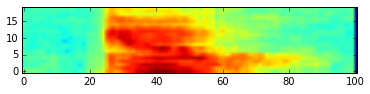

In [22]:
plt.imshow(melfbanks.transform(random_wav).transpose())
plt.gca().invert_yaxis()

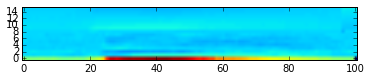

In [23]:
plt.imshow(mfcc.transform(random_wav).transpose())
plt.gca().invert_yaxis()

# See what your classifier has predicted

In [24]:
print label_set[neural_net.predict(valid_feats[random_idx][np.newaxis])[0]]

go


# What you are expected to do in this TP
This notebook contains the different blocks that allow you to train speech commands recognizers. The results provided with the features and classifiers above are far from optimal.

You are expected to explore various ways to improve their performance. Here are the main things to try:
* The parameters of the speech features such as the min/max frequency or window size are poorly chosen, look inside the resources mentioned in the class to find the best parameters for mel-filterbanks and MFCC.
* The logistic regression can be regularized in different ways (by controlling the C parameter) and you can try to find the best one
* The neural net proposed is a shallow neural net, far from the best you can train. You should try bigger, deeper architectures, different types of regularization, activation functions, learning rate and so on
* A standard way of improving generalization is to do mean-variance normalization on your data set. This is done by computing the mean and variance of each feature dimension on the entire training set, and then use it to normalize train, valid and test set
* The dataset provides noises samples, either artificial (pink, white noise) or real (dishes, bike) in the folder _background_noise. You can try augmenting your dataset by adding noise to the waveforms before computing the features
* The model is only trained on 300 examples per class, if your hardware allows it, try training on more examples
* Feel free to also experiment with different classifiers

You should find the best model by comparing validation accuracies. After you find your best model, finally test it on the test set and print the result. Comment on the results (best model, best features, classes that are the most difficult to recognize). The grade will not depend on the performance of the final system, but on how you experimented, tried different ideas, and comment on them.

Write your comments in Markdown cells, and send the ipython notebook as your assignment. Good luck!

[Documentation for logistic regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

[Documentation for neural network](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

## Try different parametres

In [39]:
# use different params for Spectral function
# in page 30 of the slides, we choose 25ms as the window size and 
# 10 ms as the window step.
melfbanks_1 = spectral.Spectral(nfilt=20,
                    ncep=0,
                    do_dct=False,
                    lowerf=500,
                    upperf=5000,
                    alpha=0.6,
                    fs=framerate,
                    frate=100,
                    wlen=0.025,  # change to 25 ms
                    nfft=512, 
                    compression='log',
                    do_deltas=False,
                    do_deltasdeltas=False)

In [40]:
## try new parametres with melfbanks_1

In [41]:
def get_feats(feature_function):
    start = time.time()
    train_feats = np.asarray(pad(transform_wavs(train_wavs, feature_function)))
    valid_feats = np.asarray(pad(transform_wavs(valid_wavs, feature_function)))
    test_feats = np.asarray(pad(transform_wavs(test_wavs, feature_function)))
    end = time.time()

    print "Time to output features: " + str(end-start)
    return train_feats, valid_feats, test_feats

def logistic_(train_feats, valid_feats):
    #Logistic regression
    logreg = sklearn.linear_model.LogisticRegression(verbose=1, tol=1e-3, random_state=777)

    start = time.time()
    logreg.fit(train_feats, train_labels)
    end = time.time()

    print "Training time: " + str(end-start)
    
    print "Accuracy on valid set " + str(100*logreg.score(valid_feats, valid_labels)) + "%"

In [42]:
tra_feats, val_feats, tes_feats = get_feats(melfbanks_1)
logistic_(tra_feats, val_feats)

Time to output features: 35.2788851261
[LibLinear]Training time: 99.5837199688
Accuracy on valid set 34.9%


In [ ]:
# lower rf = 50, seems to have a more accuracy result

In [43]:
melfbanks_2 = spectral.Spectral(nfilt=20,
                    ncep=0,
                    do_dct=False,
                    lowerf=50,
                    upperf=5000,
                    alpha=0.6,
                    fs=framerate,
                    frate=100,
                    wlen=0.025,  # change to 25 ms
                    nfft=512, 
                    compression='log',
                    do_deltas=False,
                    do_deltasdeltas=False)
tra_feats, val_feats, tes_feats = get_feats(melfbanks_2)
logistic_(tra_feats, val_feats)

Time to output features: 38.32954216
[LibLinear]Training time: 92.2092349529
Accuracy on valid set 39.0%


In [47]:
framerate

16000

In [44]:
## try new parametres with MFCC, do deltasdeltas
mfcc_1 = spectral.Spectral(nfilt=20,
                    ncep=8,
                    do_dct=True,
                    lowerf=500,
                    upperf=5000,
                    alpha=0.6,
                    fs=framerate,
                    frate=100,
                    wlen=0.035,
                    nfft=512,
                    compression='log',
                    do_deltas=True,
                    do_deltasdeltas=True)
tra_feats, val_feats, tes_feats = get_feats(mfcc_1)
logistic_(tra_feats, val_feats)

Time to output features: 37.2041938305
[LibLinear]Training time: 91.2201218605
Accuracy on valid set 36.6%


In [ ]:
%%cache
# control the C / alpha: do a cross validation if time permits.
# here just do a cycle: very slow.
for alpha in [0.1, 0.3, 0.5, 0.6, 0.7, 0.8]:
    mfcc_2 = spectral.Spectral(nfilt=20,
                    ncep=8,
                    do_dct=True,
                    lowerf=500,
                    upperf=5000,
                    alpha=alpha,
                    fs=framerate,
                    frate=100,
                    wlen=0.035,
                    nfft=512,
                    compression='log',
                    do_deltas=True,
                    do_deltasdeltas=False)
    print("for the case where alpha = ", alpha)
    tra_feats, val_feats, tes_feats = get_feats(mfcc_2)
    logistic_(tra_feats, val_feats)

In [45]:
#The neural net proposed is a shallow neural net, 
#far from the best you can train. You should try bigger, 
#deeper architectures, different types of regularization, 
#activation functions, learning rate and so on

## Deep Net by scrach

We saw at below that with an "adam" optimizer and with 1 layer "relu", the network gives a good results for accuracy

In [50]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras import optimizers

In [58]:
np.array(train_feats).shape, np.array(train_labels).shape, np.unique(train_labels)

((3000, 1616), (3000,), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

In [62]:
# transform label to categorical data one-hot type to use the softmax function
from keras.utils.np_utils import to_categorical
Y_train = to_categorical(train_labels)
Y_train.shape

(3000, 10)

In [82]:
N = train_feats.shape[1]
H = 100
K = 10

model = Sequential()
model.add(Dense(H, input_dim=N))
model.add(Activation("relu"))
model.add(Dense(K))
model.add(Activation("softmax"))

model.compile(optimizer="adam",
              loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_feats, Y_train, epochs=100, batch_size=32)

Epoch 1/100
3000/3000 [==============================] - 2s 514us/step - loss: 2.2031 - acc: 0.2870

In [84]:
# test the data on the validation set
trues = np.sum(model.predict_classes(x=valid_feats) == valid_labels) 
num = len(valid_labels)
float(trues)/num

0.68

In [85]:
## still, we saw that the validation set result is not that good, 
## it shows an overfitting compared with the training result 0.9
## yet it's already much better than the MLP

## Renormalization

We saw at below that after standardize the data to mean 0 and standard error 1, the learning process converges much more quick, though the accuracy on the valid data didn't seem to improve much.

In [ ]:
## A standard way of improving generalization is to do mean-variance normalization 
#on your data set. This is done by computing the mean and variance of each feature dimension on 
#the entire training set, 
#and then use it to normalize train, valid and test set

In [103]:
from sklearn import preprocessing

In [104]:
preprocessing.StandardScaler??

In [105]:
scaler = preprocessing.StandardScaler()

In [106]:
std_train_feats = scaler.fit_transform(train_feats)

In [107]:
# check
std_train_feats.mean(axis=0), std_train_feats.std(axis=0)

(array([ -3.51737158e-16,   2.18713936e-17,   2.33516910e-16, ...,
          1.27307424e-15,   2.74974488e-15,  -2.24324263e-15]),
 array([ 1.,  1.,  1., ...,  1.,  1.,  1.]))

In [110]:
# retry the neural_net deep
N = std_train_feats.shape[1]
H = 100
K = 10

model = Sequential()
model.add(Dense(H, input_dim=N))
model.add(Activation("relu"))
model.add(Dense(K))
model.add(Activation("softmax"))

model.compile(optimizer="adam",
              loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(std_train_feats, Y_train, epochs=20, batch_size=32)

Epoch 1/20
3000/3000 [==============================] - 2s 503us/step - loss: 1.9113 - acc: 0.4160

In [111]:
std_valid_feats = scaler.transform(valid_feats)
std_valid_feats

array([[  4.66627036e-01,   1.21169322e-01,  -4.04815100e-01, ...,
         -9.61780431e-01,  -9.61780431e-01,  -9.61780431e-01],
       [  9.27748852e-01,   9.50568029e-01,  -3.92809770e-01, ...,
         -1.31333339e+00,  -1.31333339e+00,  -1.31333339e+00],
       [  9.02596382e-01,   8.14485457e-01,  -9.02930355e-01, ...,
         -1.47863419e+00,  -1.47863419e+00,  -1.47863419e+00],
       ..., 
       [  1.75183052e+00,  -5.04157136e-04,   8.37768561e-01, ...,
          5.64591457e-01,   5.64591457e-01,   5.64591457e-01],
       [ -9.15802738e-01,  -2.53482470e-01,   1.64945406e-01, ...,
          6.71763960e-01,   6.71763960e-01,   6.71763960e-01],
       [ -4.11921923e+00,   6.54359405e-01,   1.23071881e+00, ...,
          1.33758048e+00,   1.33758048e+00,   1.33758048e+00]])

In [112]:
# test the data on the validation set
trues = np.sum(model.predict_classes(x=std_valid_feats) == valid_labels) 
num = len(valid_labels)
float(trues)/num

0.654

## Data Augmenting

- I tried augmenting the dataset by adding each noise to every waveforms before computing the features, thus we have in total a training set of size 21000.
- The process of transforming wave data to feats gets very slow on my laptop. 
- The training accuracy got slowly but stably up.
- It's clear that augmenting the data makes it more robust (and importantly, makes overfitting less possible)

In [119]:
import os
noise_list = os.listdir('./_background_noise_/')
noise_list = list(map(lambda x: './_background_noise_/' +  x, noise_list))
noise_list

['./_background_noise_/doing_the_dishes.wav',
 './_background_noise_/dude_miaowing.wav',
 './_background_noise_/exercise_bike.wav',
 './_background_noise_/pink_noise.wav',
 './_background_noise_/README.md',
 './_background_noise_/running_tap.wav',
 './_background_noise_/white_noise.wav']

In [145]:
fs, dishes = wav.read(noise_list[0])
random_idx = random.randint(0, len(valid_wavs))
random_wav = valid_wavs[random_idx]
augwav = random_wav + dishes[10:10+framerate]*0.5

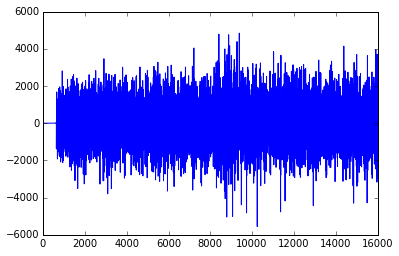

In [146]:
plt.plot(dishes[10:10+framerate])

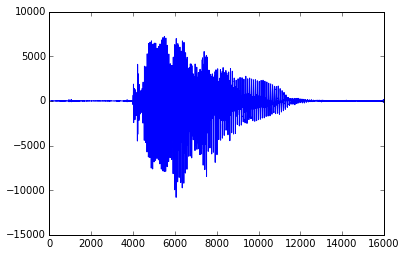

In [147]:
plt.plot(random_wav)

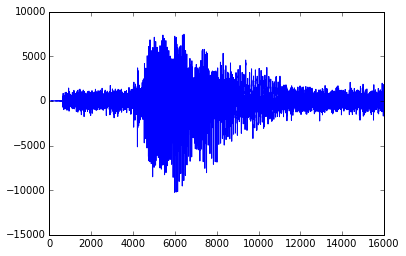

In [151]:
# after combination
plt.plot(augwav)

In [149]:
IPython.display.Audio(random_wav, rate=16000)

In [150]:
IPython.display.Audio(augwav, rate=16000)

In [154]:
# add noise background to the training set 
train_wavs[0]

array([ 3,  1,  6, ..., -1, -3,  4], dtype=int16)

In [157]:
# Iterate over files
import scipy.io.wavfile as wav

train_wavs_aug = []
train_labels_aug = train_labels * len(noise_list)
for noise_name in noise_list:
    fs, noise = wav.read(noise_list[0])
    random_idx = random.randint(0, len(noise)-framerate)
    for w in train_wavs:
        if len(w) == framerate:
            augwav = w + noise[random_idx : random_idx+framerate]*0.5
        else:
            augwav = w + noise[random_idx : random_idx+len(w)]*0.5
        train_wavs_aug.append(augwav)

print("the augmented noise-background voice has a length of", len(train_wavs_aug))

('the augmented noise-background voice has a length of', 21000)


In [166]:
IPython.display.Audio(train_wavs_aug[10000], rate=16000)

In [165]:
label_set[train_labels_aug[10000]]

'nine'

In [168]:
%%cache
# add the noise-back ground augmented data to original data set
mix_train_sets = train_wavs_aug + train_wavs
mix_label_sets = train_labels_aug + train_labels

feature_function = mfcc
train_feats = np.asarray(pad(transform_wavs(mix_train_sets, feature_function)))

In [170]:
mix_Y_train = to_categorical(mix_label_sets)

In [173]:
# retry the neural_net deep
N = train_feats.shape[1]
H = 100
K = 10

model = Sequential()
model.add(Dense(H, input_dim=N))
model.add(Activation("relu"))
model.add(Dense(K))
model.add(Activation("softmax"))

model.compile(optimizer="adam",
              loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_feats, mix_Y_train, epochs=100, batch_size=32)

Epoch 1/100
24000/24000 [==============================] - 8s 319us/step - loss: 1.9594 - acc: 0.3319

#### remark: the transform process is very slow, where I put a cache; the training process is slow on my computer, where I put the number of iteration to 100, larger n_iter may lead to better validation accuracy rate

In [174]:
# test the data on the validation set
trues = np.sum(model.predict_classes(x=valid_feats) == valid_labels) 
num = len(valid_labels)
float(trues)/num

0.637